In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
import PIL
from PIL import Image
import pandas as pd
import numpy as np
from numpy import uint8
import matplotlib.pyplot as plt

from torchcontrib.optim import SWA
from copy import deepcopy
from tqdm import tqdm

In [2]:
# Create a custom classification model
class MRIModel(nn.Module):
    def __init__(self, num_classes):
        super(MRIModel, self).__init__()
        self.pretrained_model = models.resnet50(pretrained=True)
        self.fc = nn.Linear(2048, num_classes)  # Modify the input size based on the pretrained model's output
        
    def forward(self, x):
        x = self.pretrained_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [3]:
net = resnet50(pretrained = True)
modelOutFeats = net.fc.in_features
device = torch.device(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
net.fc = nn.Sequential(
               nn.Linear(modelOutFeats, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

net = net.to(device)

In [4]:
#data.head()

NameError: name 'data' is not defined

In [7]:
## load data 
import pandas as pd
data = pd.read_csv('/sc/arion/projects/shenl03_ml/2023_adriana_bc_risk/Mirai_test/Mirai/data/mssm_mammogram_metadata_for_mirai_w_device.csv')
data.head()

# Split the data based on the split_group column
train_data = data[data['split_group'] == 'train']
test_data = data[data['split_group'] == 'test']
dev_data = data[data['split_group'] == 'dev']

# Split the data into features (image paths) and labels
train_paths = train_data['file_path'].tolist()
train_labels = train_data['device_name'].tolist()

test_paths = test_data['file_path'].tolist()
test_labels = test_data['device_name'].tolist()

dev_paths = dev_data['file_path'].tolist()
dev_labels = dev_data['device_name'].tolist()

# Print the number of samples in each split
print("Training samples:", len(train_paths)) #4151
print("Testing samples:", len(test_paths)) #925
print("Development samples:", len(dev_paths)) #925

Training samples: 4151
Testing samples: 925
Development samples: 922


In [8]:
# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        
        image_path = self.image_paths[index]
        image = PIL.Image.open(image_path)
        image_arr = np.array(PIL.Image.open(image_path), dtype = float)
        image_arr = image_arr * 255 / image_arr.max()
        image_arr = image_arr.astype(uint8)
        image_t = Image.fromarray(image_arr)

        label = self.labels[index]
        #label = torch.tensor(label, dtype=torch.int64)
        
        if self.transform:
            image = self.transform(image_t)
        
        return image, label

In [9]:
# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.25),
    transforms.RandomRotation(degrees=(0,180)),
    #transforms.GaussianBlur(kernel_size=(5, 9)), #test this
    #transforms.RandomPerspective(distortion_scale=0.6, p=1.0), #test this
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.ConvertImageDtype(torch.float),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #this makes the data -2 to 2 scale
    transforms.Normalize(mean=[0.4490, 0.4490, 0.4490], std=[0.3236, 0.3236, 0.3236]) #these are the true mean and std
]) 

validation_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.ConvertImageDtype(torch.float), #https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=[0.4490, 0.4490, 0.4490], std=[0.3236, 0.3236, 0.3236])
])

In [10]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder instance
label_encoder = LabelEncoder()

# Fit the label encoder on the combined labels
all_labels = train_labels + test_labels + dev_labels
label_encoder.fit(all_labels)

# Map the string labels to numerical values
train_labels_encoded = label_encoder.transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
dev_labels_encoded = label_encoder.transform(dev_labels)

torch.Size([3, 224, 224])


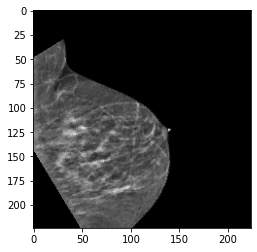

In [11]:
# Create custom datasets
train_dataset = CustomDataset(train_paths, train_labels_encoded, transform=transform)
test_dataset = CustomDataset(test_paths, test_labels_encoded, transform=validation_transform)
dev_dataset = CustomDataset(dev_paths, dev_labels_encoded, transform=validation_transform)

image, label = train_dataset[1]
image
plt.imshow(image.numpy()[0], cmap='gray')
label, image.size()
print(image.size())

In [12]:
# Define the batch size for training and testing
batch_size = 64

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

In [13]:
batch = next(iter(train_loader))
print('len', len(train_loader))
images, labels = batch
print('types:', type(images), type(labels))
print('shapes:', images.shape, labels.shape)
images[0].shape
labels[0]

len 65
types: <class 'torch.Tensor'> <class 'torch.Tensor'>
shapes: torch.Size([64, 3, 224, 224]) torch.Size([64])


tensor(0)

In [14]:
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
import torchcontrib
from torch.optim.lr_scheduler import CosineAnnealingLR

net_final = deepcopy(net)

loss_fn = nn.CrossEntropyLoss()

#Adam 
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas = (0.9, 0.99), weight_decay=1e-4) #Adam
scheduler = CosineAnnealingLR(optimizer, T_max=32)

optimizer = torch.optim.Adam(net.parameters())

n_epochs =  10

top_accuracy_val = 0
train_acc_all = [] #visualization
train_losses = []
val_acc_all = []
validation_losses = []

for epoch in range(n_epochs):
    
    net.train() #.train -- parameters can be changed 
    
    # train accuracy = number correct / total trained 
    total_trained = 0

    # the number of examples classified correctly
    correct = 0
    
    #total to iterate through
    total = len(train_dataset)//batch_size #int division
    
    running_loss = 0
    #tqdm - progress bar 
    for batch_index, (inputs, target) in tqdm(enumerate(train_loader), total=total):
      # load the data onto the computation device.
    
        inputs, target = inputs.to(device), target.to(device)
        
            
        optimizer.zero_grad() #set gradients to 0 at each iteration (default: adding up)
        pred = net(inputs.float()) #predictions --> floats
        #loss = loss_fn(pred, target) #backprop 
        loss = loss_fn(pred, target)#.backward()
        loss.backward()
        #running_loss += loss.item()

        optimizer.step() #adjust parameters collected in backward pass
        
        #optimizer.first_step()
        loss_fn(net(inputs.float()), target).backward()
        #optimizer.second_step()
        running_loss += loss.item()
        
        
        
        #Prediction
        _, pred_class = pred.max(1) #max value 
        total_trained += pred_class.size(0)
        correct += pred_class.eq(target).sum().item() #take item()
    
    scheduler.step()

    train_loss=running_loss/len(train_loader)
    train_losses.append(train_loss)
    accuracy = correct / total_trained
    train_acc_all.append(accuracy)
    print("Train Accuracy and loss: {}".format(accuracy), train_loss)
        
    #validation 
    best_val_acc = 0
    net.eval() 
    total_validated = 0

    # the number of examples classified correctly
    correct = 0
    running_loss_validation = 0

    #total to iterate through
    total = len(dev_dataset)//batch_size #int division

    with torch.no_grad():
        for batch_index, (inputs, target) in tqdm(enumerate(dev_loader), total=total):

            inputs = inputs.to(device) #load data 
            target = target.to(device)
            
            #Prediction and Loss
            pred = net(inputs.float()) #predictions --> floats
            #pred = swa_model(inputs.float())
            loss = loss_fn(pred, target)
            running_loss_validation += loss.item()
            
            _, pred_class = pred.max(1) #max value 
            total_validated += pred_class.size(0)
            correct += pred_class.eq(target).sum().item() #take item()

    val_accuracy = correct / total_validated
    val_acc_all.append(val_accuracy)
    validation_loss=running_loss_validation/len(dev_loader)
    validation_losses.append(validation_loss)
    print("Validation Accuracy and Loss: {}".format(val_accuracy), validation_loss)
    
    #Saving the best model
    if val_accuracy > top_accuracy_val: 
        print("Saving better model")
        top_accuracy_val = val_accuracy
        net_best_saved = deepcopy(net)
        #Save model 
        torch.save(net, '/sc/arion/projects/shenl03_ml/2023_adriana_bc_risk/Mirai_test/Mirai/model_resnet_mri_device_classifier.pth')
        

65it [09:29,  8.76s/it]                        
/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Accuracy and loss: 0.9407371717658396 0.16327549270712413


15it [02:03,  8.21s/it]                        


Validation Accuracy and Loss: 0.9501084598698482 0.13086742659409842
Saving better model


65it [07:36,  7.02s/it]                        


Train Accuracy and loss: 0.9590460130089136 0.11807601226923557


15it [01:34,  6.31s/it]                        


Validation Accuracy and Loss: 0.7581344902386117 0.6891092697779337


65it [07:31,  6.94s/it]                        


Train Accuracy and loss: 0.9744639845820284 0.08041869106774147


15it [01:39,  6.66s/it]                        


Validation Accuracy and Loss: 0.9164859002169198 0.26421826283137


65it [07:48,  7.20s/it]                        


Train Accuracy and loss: 0.9732594555528788 0.0788352040717235


15it [01:36,  6.46s/it]                        


Validation Accuracy and Loss: 0.6626898047722343 1.0847958286603292


65it [07:34,  6.99s/it]                        


Train Accuracy and loss: 0.9759094194170079 0.07293135298129458


15it [01:36,  6.43s/it]                        


Validation Accuracy and Loss: 0.5162689804772235 1.886605974038442


65it [07:43,  7.13s/it]                        


Train Accuracy and loss: 0.9775957600578173 0.07122673315640826


15it [01:43,  6.91s/it]                        


Validation Accuracy and Loss: 0.6800433839479393 0.7030761539936066


65it [07:53,  7.28s/it]                        


Train Accuracy and loss: 0.9780775716694773 0.06532463531654614


15it [01:40,  6.73s/it]                        


Validation Accuracy and Loss: 0.46203904555314534 1.196158023675283


65it [07:49,  7.22s/it]                        


Train Accuracy and loss: 0.9785593832811371 0.06719286985552082


15it [01:40,  6.71s/it]                        


Validation Accuracy and Loss: 0.4370932754880694 1.9775669654210408


65it [07:43,  7.13s/it]                        


Train Accuracy and loss: 0.9771139484461575 0.06417412722769839


15it [01:36,  6.46s/it]                        


Validation Accuracy and Loss: 0.9078091106290672 0.2665699109435081


65it [07:35,  7.01s/it]                        


Train Accuracy and loss: 0.9804866297277764 0.05309811616674639


15it [01:35,  6.39s/it]                        

Validation Accuracy and Loss: 0.4164859002169197 1.8042956352233888


In [ ]:
  #Saving the best model
    if val_accuracy > top_accuracy_val: 
        print("Better model")
        top_accuracy_val = val_accuracy
        net_best_saved = deepcopy(net)
        #Save model 
        torch.save(net, '/sc/arion/projects/shenl03_ml/2023_adriana_bc_risk/ML_2022/model_resnet_weights_128_batch.pth')